In [10]:
from gcn_ltsm import *
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
def data_preparation(datafile):
    lat_range = {'min': 28.486, 'max': 28.72}
    long_range = {'min': 77.1, 'max': 77.32}
    n_lat_grid = 25
    n_long_grid = 25
    
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @180min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    #taking only data from 6Am-12midnight
    df = df[(df.dateTime>=360)] 
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    df = df.fillna(0)
    return df


In [8]:
def main_forecast(df, gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr, test_date, history_days):
    model = define_model(gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr)
    # history_path = 'results3/scratch/' + test_date
    history_path = None
    trainX, trainY, testX, testY, train_data = prepare_train_data(df)
    out = train_model(model, 100, 19, trainX, trainY, testX, testY, train_data, history_path)
    out['GCN sizes'] = [gc_sizes]
    out['LSTM sizes'] = [lstm_sizes]
    out['History (in days)'] = [history_days]
    out['Test Date'] = [test_date]
    display(out)
    test_output, test_true = eval_model(model, testX, testY, train_data)
    plot_predictions(test_output, test_true)
    return out

/efs/litmus-server/users/yguptgau/Pollution/Forecasting/gcn_ltsm.py:166: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm = GCN_LSTM(


,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss,Train time callbacks,GCN sizes,LSTM sizes,History (in days),Test Date
0,61.80504,52.345586,57.373195,49.159568,6.326806,"[4, 4]",[4],6,7 Dec


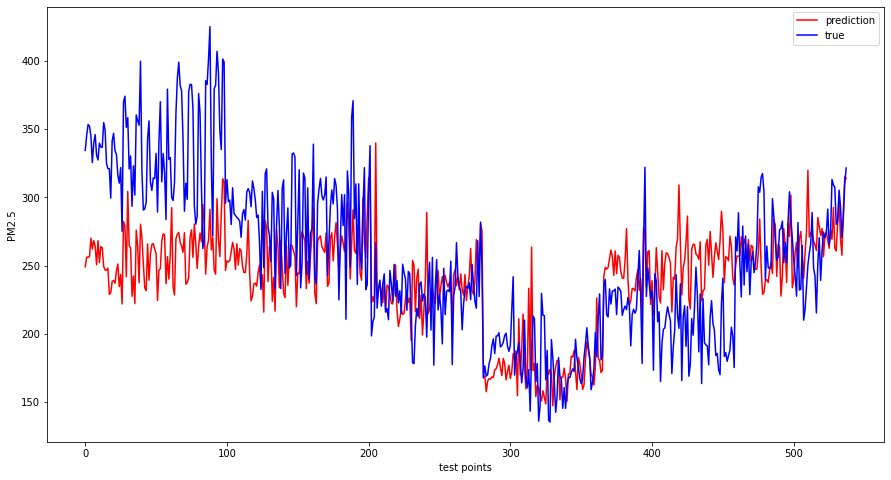

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss,Train time callbacks,GCN sizes,LSTM sizes,History (in days),Test Date
0,61.80504,52.345586,57.373195,49.159568,6.326806,"[4, 4]",[4],6,7 Dec


In [9]:
df = pd.read_csv('Data/Test Days/Dummy_data_1week_7Dec.csv')
df = df.set_index(['lat_grid','long_grid'])
main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '7 Dec', 6)